<a href="https://colab.research.google.com/github/1ramkumar/Stock_Prediction-using-LSTM/blob/main/Stock_Prediction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

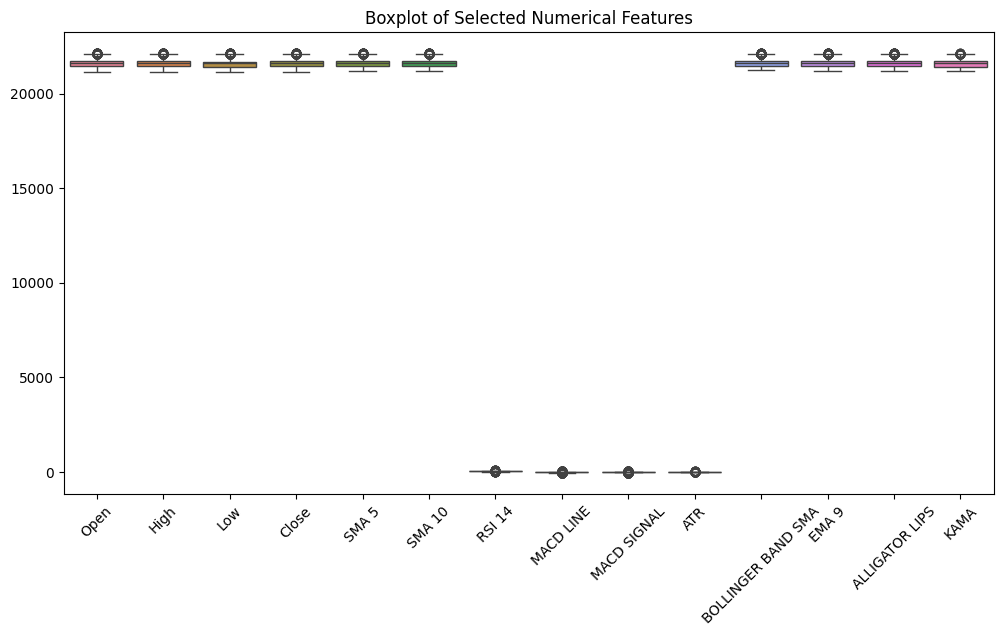

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import utils
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
data_file_path = r"/content/updated_dataframe_part2.csv"  # Corrected path to Google Drive
df_file = pd.read_csv(data_file_path)

# Outliers detection
num_cols = [
    col for col in [
        'Open', 'High', 'Low', 'Close',
        'SMA 5','SMA 10','SMA 50','RSI 14',
        'MACD LINE','MACD SIGNAL', 'ATR',
        'BOLLINGER BAND SMA','BOLLINGER BAND UPPER',
        'BOLLINGER BAND LOWER', 'EMA 9',
        'ALLIGATOR JAW ','ALLIGATOR TEETH',
        'ALLIGATOR LIPS','KAMA'
    ]
    if col in df_file.columns
]
plt.figure(figsize=(12,6))
sns.boxplot(data=df_file[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplot of Selected Numerical Features")
plt.show()

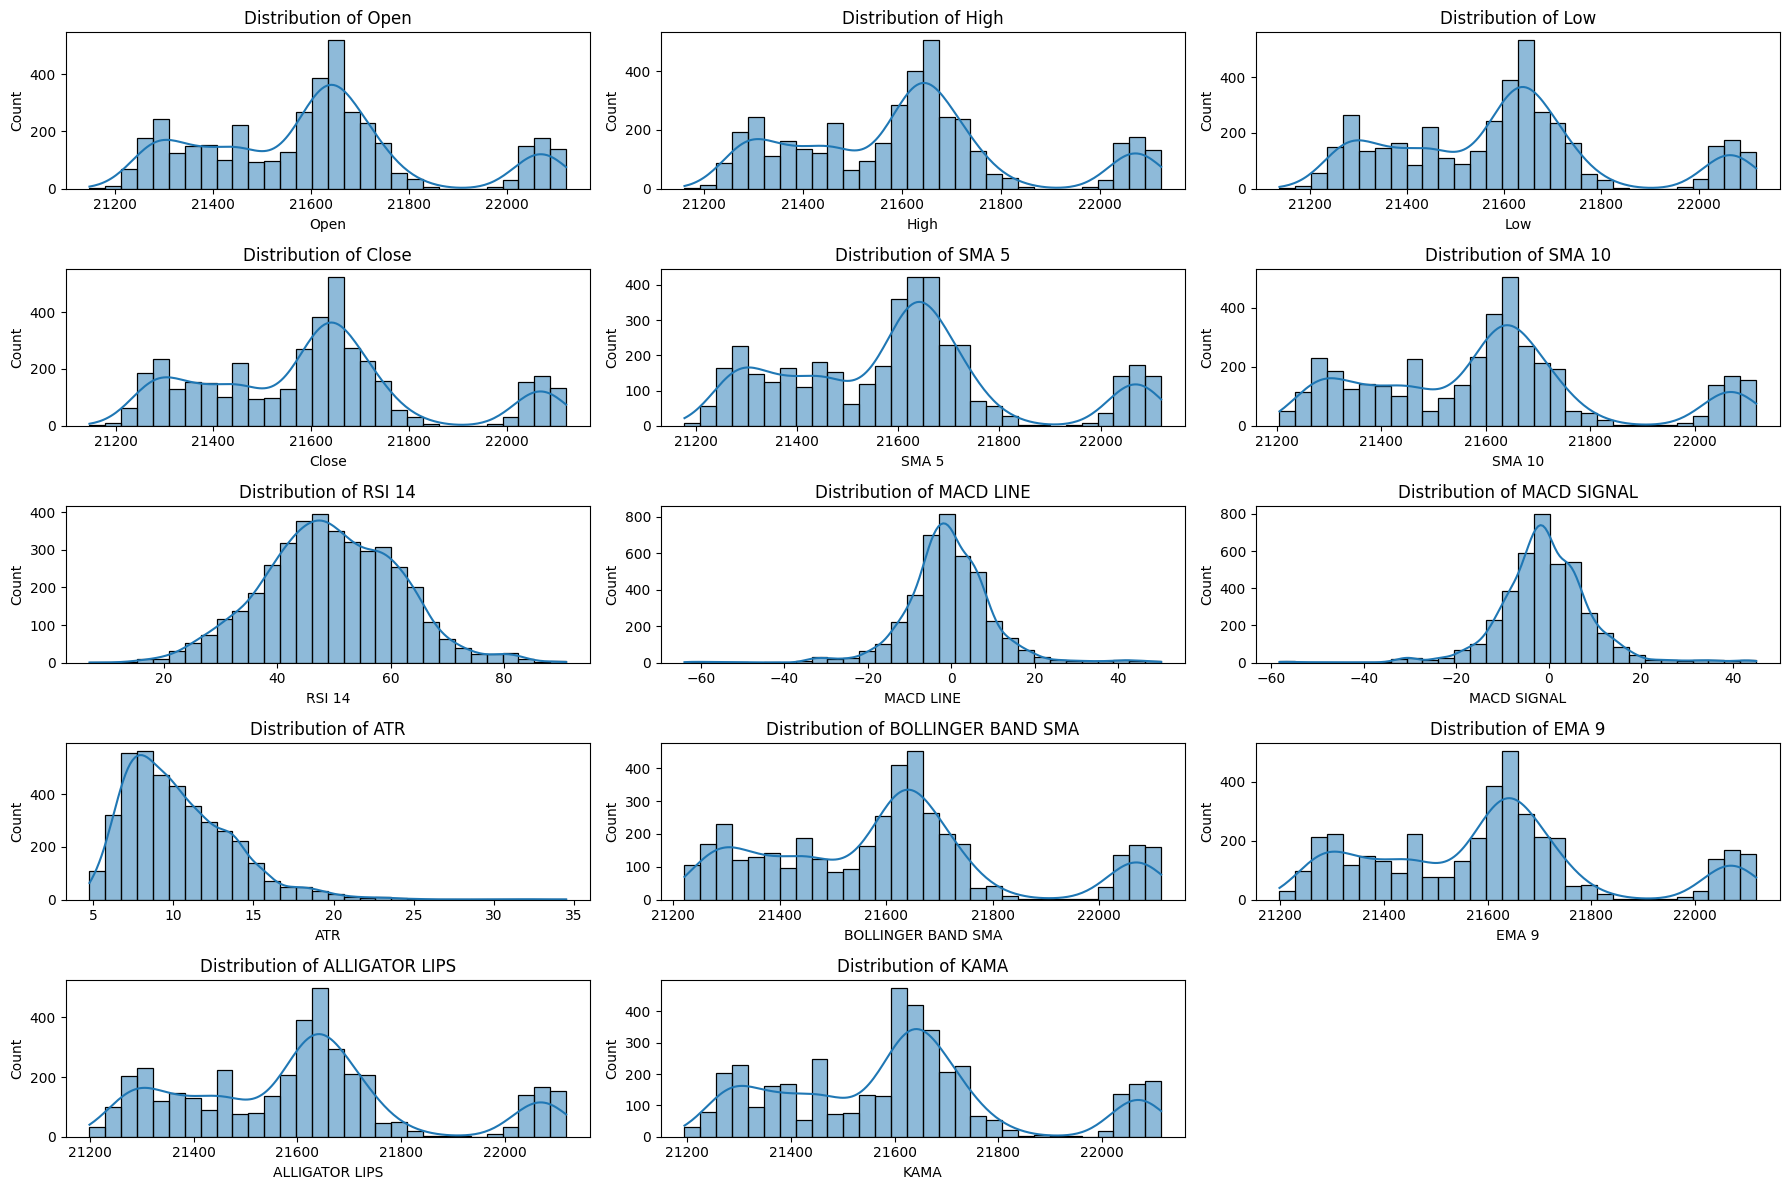

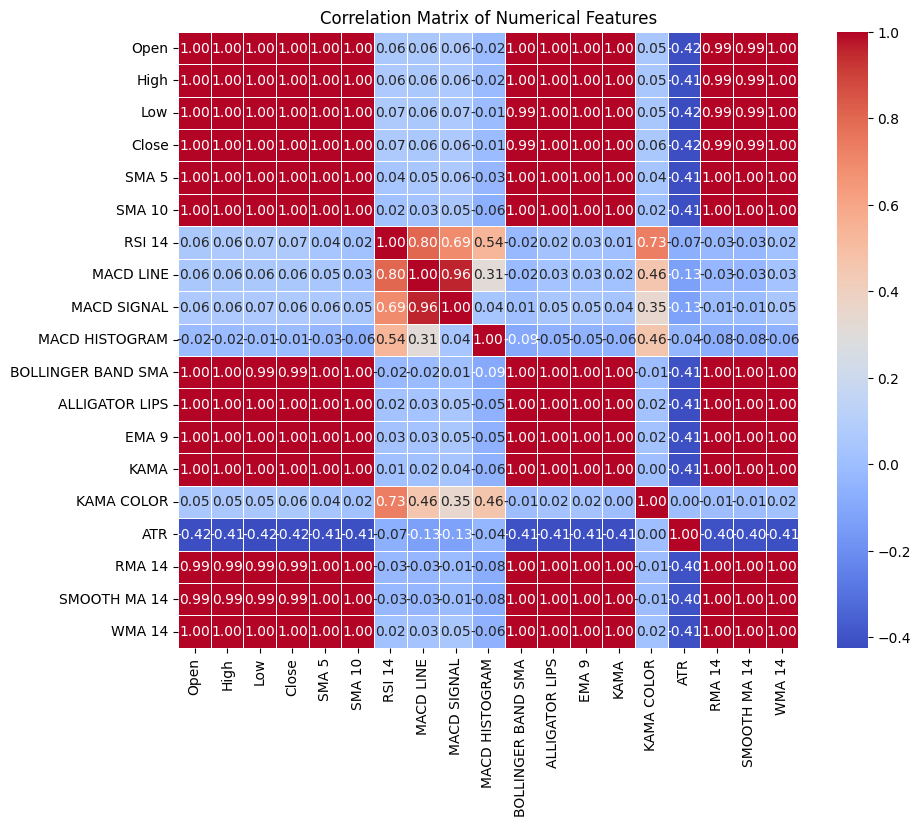

Correlation with 'Close':
Close                 1.000000
High                  0.999775
Low                   0.999705
Open                  0.999380
SMA 5                 0.998934
EMA 9                 0.998487
ALLIGATOR LIPS        0.998272
WMA 14                0.997960
SMA 10                0.997607
KAMA                  0.997429
BOLLINGER BAND SMA    0.994901
RMA 14                0.994581
SMOOTH MA 14          0.994581
RSI 14                0.068772
MACD SIGNAL           0.064732
MACD LINE             0.058179
KAMA COLOR            0.055926
MACD HISTOGRAM       -0.011881
ATR                  -0.416270
Name: Close, dtype: float64


In [ ]:

# Plotting histograms
plt.figure(figsize=(18, 12))
num_plots = len(num_cols)
cols = 3
rows = (num_plots // cols) + int(num_plots % cols != 0)
for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_file[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation matrix for original numeric columns
corr_matrix = df_file.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

if 'Close' in corr_matrix.columns:
    print("Correlation with 'Close':")
    print(corr_matrix['Close'].sort_values(ascending=False))

columns_to_remove = [
    'Volume', 'SMA 50', 'BOLLINGER BAND UPPER',
    'BOLLINGER BAND LOWER', 'ALLIGATOR JAW',
    'ALLIGATOR TEETH'
]
df_file = df_file.drop(columns=[col for col in columns_to_remove if col in df_file.columns])

# Save updated dataframe (optional)
df_file.to_csv("updated_dataframe.csv", index=False)

In [ ]:
# Generating label
def generate_labels(df, open_col='Open', close_col='Close', lookahead=5):
    n = len(df)
    labels = [None] * n
    for i in range(n - lookahead):
        window = df.iloc[i+1 : i+1+lookahead]
        green = (window[close_col] > window[open_col]).values
        red = (window[close_col] < window[open_col]).values
        if green.all():
            labels[i] = 0  # Uptrend
        elif red.all():
            labels[i] = 1  # Downtrend
        else:
            labels[i] = 2  # Neutral
    return labels

df_file['label'] = generate_labels(df_file, lookahead=5)
print("Value counts:")
print(df_file['label'].value_counts(dropna=False))

# Check if 'label' column exists before dropping
if 'label' in df_file.columns:
    df_file = df_file.drop(columns=['label'])


Value counts:
label
2.0    3784
0.0     111
1.0     100
NaN       5
Name: count, dtype: int64


In [ ]:
#Feature Engineering
def engineer_features(df):
    df = df.copy()

    # SMA - EMA differences for acceleration
    df["sma5_minus_ema9"] = df["SMA 5"] - df["EMA 9"]
    df["sma5_minus_sma10"] = df["SMA 5"] - df["SMA 10"]

    # MACD & RSI for momentum
    df['MACD LINE'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD SIGNAL'] = df['MACD LINE'].ewm(span=9, adjust=False).mean()

    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI 14'] = 100 - (100 / (1 + rs))

    # Bollinger Bandwidth (Volatility)
    df['BOLLINGER BANDWIDTH'] = df['BOLLINGER BAND SMA']

    return df
df = engineer_features(df_file)


In [ ]:

# Multi-step Label Generation

lookahead = 5
def generate_labels(df, open_col='Open', close_col='Close', lookahead=5):
    n = len(df)
    labels = [np.nan] * n
    for i in range(n - lookahead):
        window = df.iloc[i+1:i+1+lookahead]
        green = (window[close_col] > window[open_col]).all()
        red = (window[close_col] < window[open_col]).all()
        if green:
            labels[i] = 0  # Uptrend
        elif red:
            labels[i] = 1  # Downtrend
        else:
            labels[i] = 2  # Neutral
    df['label'] = labels
    df = df.dropna().reset_index(drop=True)
    return df

df = generate_labels(df, lookahead=lookahead)


In [ ]:

# Create sequences for LSTM

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, utils

window_size = 30  # past 30 minutes

def create_sequences(df, feature_cols, target_col='label', window_size=30):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[feature_cols].iloc[i:i+window_size].values)
        y.append(df[target_col].iloc[i+window_size])
    return np.array(X), np.array(y)

# Select feature columns (exclude 'Date Time' and 'label')
feature_cols = [col for col in df.columns if col not in ['Date Time', 'label']]

# Create sequences
X, y = create_sequences(df, feature_cols, target_col='label', window_size=window_size)
print("X shape:", X.shape)  # (num_sequences, 30, num_features)
print("y shape:", y.shape)  # (num_sequences,)

# Train / Validation / Test Split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Save splits to disk

np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train)
np.save("y_val.npy", y_val)
np.save("y_test.npy", y_test)
print("Datasets saved to disk successfully!")


#  Scaling

n_samples, seq_len, n_features = X_train.shape
X_train_flat = X_train.reshape(-1, n_features)
X_val_flat = X_val.reshape(-1, n_features)
X_test_flat = X_test.reshape(-1, n_features)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat).reshape(n_samples, seq_len, n_features)
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)
print("Sequences created and scaled successfully!")

X shape: (3951, 30, 22)
y shape: (3951,)
Datasets saved to disk successfully!
Sequences created and scaled successfully!


In [ ]:

# Build LSTM Model

from tensorflow.keras import Input

def build_lstm_model(input_shape, num_classes=3):
    model = models.Sequential([
        Input(shape=input_shape),              # Use Input instead of input_shape in LSTM
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(128),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
num_classes = 3
model = build_lstm_model(input_shape, num_classes)

# Train LSTM

y_train_cat = utils.to_categorical(y_train, num_classes)
y_val_cat = utils.to_categorical(y_val, num_classes)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=40,
    batch_size=128,
    class_weight=class_weights_dict,
    verbose=2
)

#  Evaluate Model

y_test_cat = utils.to_categorical(y_test, num_classes)
y_pred_proba = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_proba, axis=1)


#  Generate Prediction Report Table

trend_map = {0: 'Uptrend', 1: 'Downtrend', 2: 'Neutral'}

# Prepare test dataframe
df_test_report = df.iloc[-(len(y_test)+window_size):].reset_index(drop=True)
# Generate Prediction Report with 1 row per prediction
report_rows = []

for i in range(window_size, len(df_test_report)):
    row = df_test_report.iloc[i]

    # Combine Momentum indicators as one string
    momentum_str = f"RSI:{row['RSI 14']:.2f}, MACD:{row['MACD LINE']:.2f}"

    report_rows.append({
        'Date & Time': row['Date Time'],
        'Price': row['Close'],
        'Momentum': momentum_str,
        'Acceleration': row['sma5_minus_ema9'],
        'Volatility': row['BOLLINGER BANDWIDTH'],
        'Trend': trend_map[y_pred[i - window_size]]  # Predicted trend
    })

# Create DataFrame
prediction_report = pd.DataFrame(report_rows)

# Display first 10 rows
print(prediction_report.head(10))

# Save to CSV
prediction_report.to_csv("LSTM_Stock_Prediction_Report.csv", index=False)


Epoch 1/40
22/22 - 10s - 457ms/step - accuracy: 0.3027 - loss: 1.0824 - val_accuracy: 0.1804 - val_loss: 1.1649
Epoch 2/40
22/22 - 4s - 179ms/step - accuracy: 0.2597 - loss: 1.0182 - val_accuracy: 0.4705 - val_loss: 1.0009
Epoch 3/40
22/22 - 5s - 243ms/step - accuracy: 0.4694 - loss: 1.0001 - val_accuracy: 0.3592 - val_loss: 0.9796
Epoch 4/40
22/22 - 10s - 433ms/step - accuracy: 0.3013 - loss: 0.9762 - val_accuracy: 0.3187 - val_loss: 1.0767
Epoch 5/40
22/22 - 5s - 218ms/step - accuracy: 0.3555 - loss: 0.9408 - val_accuracy: 0.3187 - val_loss: 1.1154
Epoch 6/40
22/22 - 4s - 176ms/step - accuracy: 0.3714 - loss: 0.9253 - val_accuracy: 0.3761 - val_loss: 1.0246
Epoch 7/40
22/22 - 7s - 296ms/step - accuracy: 0.3982 - loss: 0.8853 - val_accuracy: 0.2799 - val_loss: 1.1505
Epoch 8/40
22/22 - 4s - 177ms/step - accuracy: 0.3544 - loss: 0.8512 - val_accuracy: 0.2901 - val_loss: 1.1621
Epoch 9/40
22/22 - 4s - 184ms/step - accuracy: 0.3718 - loss: 0.7829 - val_accuracy: 0.4452 - val_loss: 0.9143


 Model Evaluation Metrics (Multi-Class):
Accuracy: 0.7925801011804384
Precision (macro): 0.4105022510345939
Recall (macro): 0.6123319493871096
F1-score (macro): 0.43188403867744096

Classification Report:
              precision    recall  f1-score   support

     Uptrend       0.16      0.56      0.25        16
   Downtrend       0.10      0.47      0.17        15
     Neutral       0.97      0.81      0.88       562

    accuracy                           0.79       593
   macro avg       0.41      0.61      0.43       593
weighted avg       0.93      0.79      0.85       593



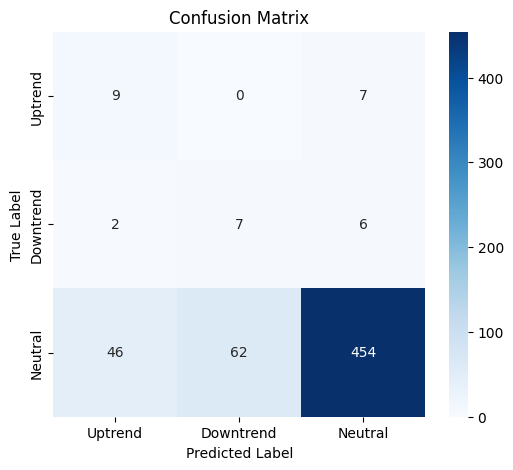

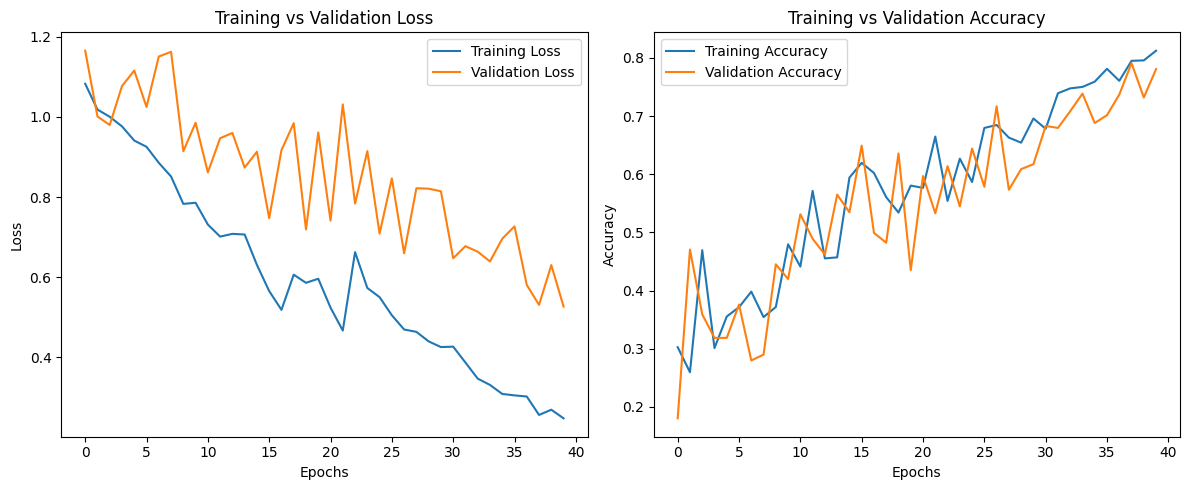

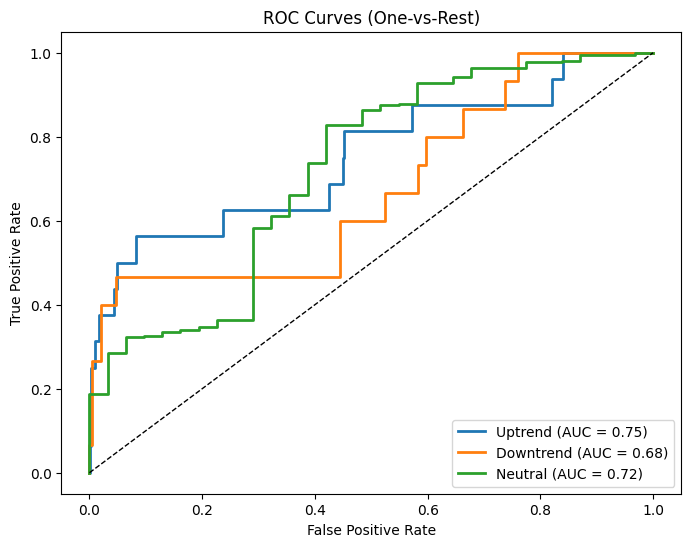

In [ ]:

#  Model Evaluation Metrics & Visualizations

from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate model performance
print("\n Model Evaluation Metrics (Multi-Class):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))

# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Uptrend', 'Downtrend', 'Neutral']))


#  Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uptrend', 'Downtrend', 'Neutral'],
            yticklabels=['Uptrend', 'Downtrend', 'Neutral'])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#  Training vs Validation Loss & Accuracy

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#  ROC Curves (One-vs-Rest)
# Binarize test labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
for i, label in enumerate(['Uptrend', 'Downtrend', 'Neutral']):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
